In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

**EDA**

In [2]:
input_df = pd.read_csv(r'website-traffic.csv')

In [3]:
input_df.head()

,DayOfWeek,MonthDay,Year,Visits
0,Monday,June 1,2009,27
1,Tuesday,June 2,2009,31
2,Wednesday,June 3,2009,38
3,Thursday,June 4,2009,38
4,Friday,June 5,2009,31


In [4]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   DayOfWeek  214 non-null    object
 1   MonthDay   214 non-null    object
 2   Year       214 non-null    int64 
 3   Visits     214 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 6.8+ KB


In [5]:
input_df['date_of_visit'] = pd.to_datetime(input_df.MonthDay.str.cat(input_df.Year.astype(str), sep=' '))

<ipython-input-6-5188903f9ea2>:7: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  deompose = seasonal_decompose(ts_visits.interpolate(),


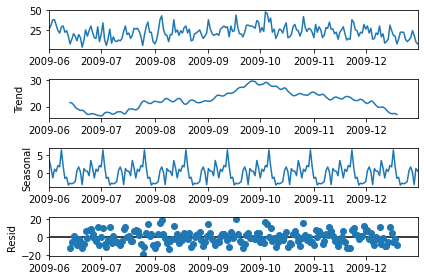

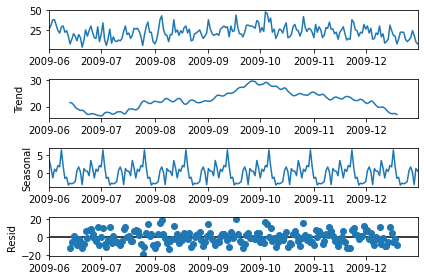

In [6]:
# extract visits as series from the dataframe
ts_visits = pd.Series(input_df.Visits.values,
                      index=pd.date_range(input_df.date_of_visit.min(),
                                          input_df.date_of_visit.max(),
                                          freq='D'))

deompose = seasonal_decompose(ts_visits.interpolate(),
                              freq=24)
deompose.plot()

No handles with labels found to put in legend.


   Visits  moving_average
0      27             NaN
1      31             NaN
2      38       32.000000
3      38       35.666667
4      31       35.666667
5      24       31.000000
6      21       25.333333
7      29       24.666667
8      30       26.666667
9      22       27.000000


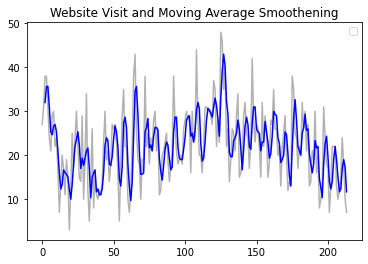

In [7]:
# moving average
input_df['moving_average'] = input_df['Visits'].rolling(window=3, center=False).mean()
print(input_df[['Visits','moving_average']].head(10))
plt.plot(input_df.Visits,'-',color='black',alpha=0.3)
plt.plot(input_df.moving_average,color='b')
plt.title('Website Visit and Moving Average Smoothening')
plt.legend()
plt.show()

No handles with labels found to put in legend.


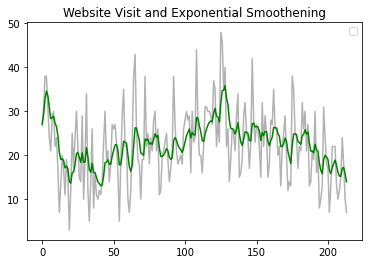

In [8]:
# exponential smoothing
input_df['ewma'] = input_df['Visits'].ewm(halflife=3, ignore_na=False, 
                                          min_periods=0, adjust=True).mean()
plt.plot(input_df.Visits,'-',color='black',alpha=0.3)
plt.plot(input_df.ewma,color='g')
plt.title('Website Visit and Exponential Smoothening')
plt.legend()
plt.show()

In [28]:
import quandl
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [10]:
quandl.ApiConfig.api_key = "L79QECK6YmJoVNUF3BA-"
gold_df = quandl.get("BUNDESBANK/BBK01_WT5511", end_date="2017-08-31")

In [11]:
gold_df.head()

,Value
Date,
1968-04-01,38.0
1968-04-02,37.6
1968-04-03,37.7
1968-04-04,36.7
1968-04-05,37.2


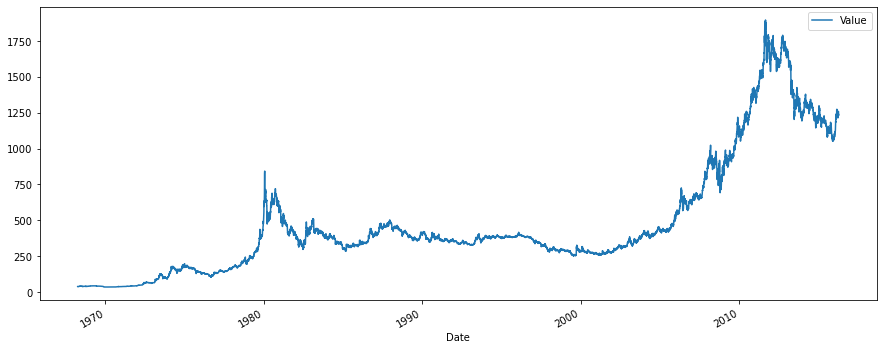

In [12]:
gold_df.plot(figsize=(15, 6))
plt.show()

In [19]:
# Dickey Fuller test for Stationarity
def ad_fuller_test(ts):
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)

# Plot rolling stats for a time series
def plot_rolling_stats(ts):
    rolling_mean = ts.rolling(window=12,center=False).mean()
    rolling_std = ts.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15, 6))
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

Test Statistic                    -0.364334
p-value                            0.915886
#Lags Used                        43.000000
Number of Observations Used    17506.000000
Critical Value (1%)               -3.430724
Critical Value (5%)               -2.861705
Critical Value (10%)              -2.566858
dtype: float64


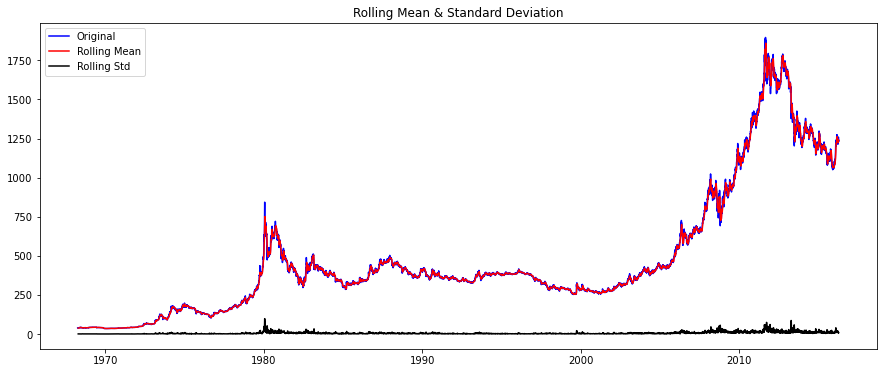

In [20]:
new_df = gold_df.reindex(pd.date_range(gold_df.index.min(), 
                                  gold_df.index.max(), 
                                  freq='D')).fillna(method='ffill')

ad_fuller_test(new_df.Value)
plot_rolling_stats(new_df.Value)

Test Statistic                    -1.903396
p-value                            0.330465
#Lags Used                        12.000000
Number of Observations Used    12139.000000
Critical Value (1%)               -3.430889
Critical Value (5%)               -2.861778
Critical Value (10%)              -2.566897
dtype: float64


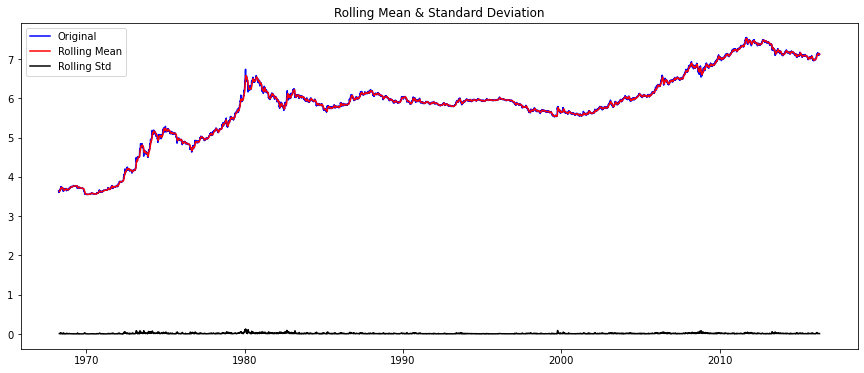

In [22]:
# log scale
log_series = np.log(gold_df.Value)
ad_fuller_test(log_series)
plot_rolling_stats(log_series)

Test Statistic                -1.680313e+01
p-value                        1.215762e-29
#Lags Used                     4.000000e+01
Number of Observations Used    1.211000e+04
Critical Value (1%)           -3.430890e+00
Critical Value (5%)           -2.861779e+00
Critical Value (10%)          -2.566897e+00
dtype: float64


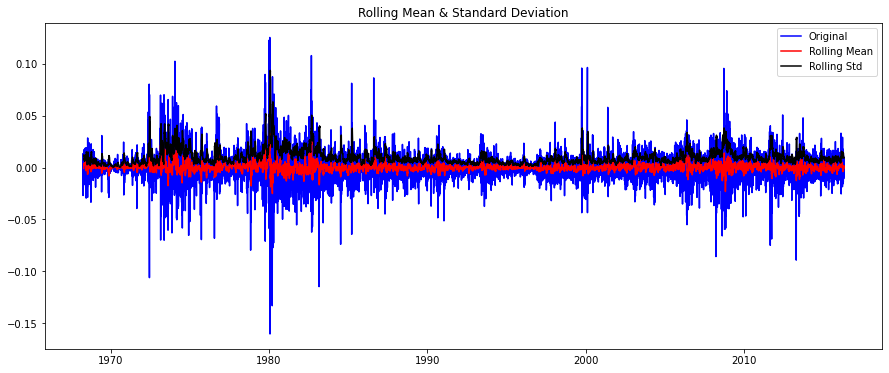

In [23]:
log_series_shift = log_series - log_series.shift()
log_series_shift = log_series_shift[~np.isnan(log_series_shift)]
ad_fuller_test(log_series_shift)
plot_rolling_stats(log_series_shift)

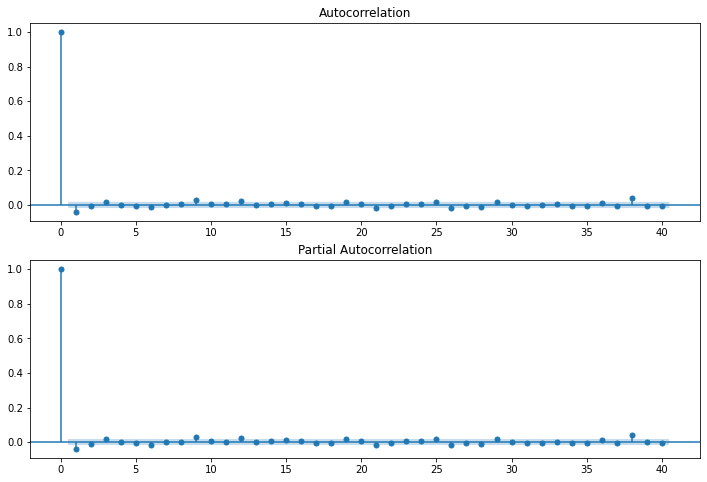

In [29]:
# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(log_series_shift.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(log_series_shift, lags=40, ax=ax2)